In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/PennyStock/pennystockpipeline /content/pennystockpipeline
!cp /content/drive/MyDrive/PennyStock/mod_historicaldata.db /content/mod_historicaldata.db

#!cp -r /content/drive/Shareddrives/PennyStock/pennystockpipeline /content/pennystockpipeline
#!cp /content/drive/Shareddrives/PennyStock/mod_historicaldata.db /content/mod_historicaldata.db

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
psd = None
model = None

from pennystockpipeline.PennyStockData import PennyStockData
import torch

torch.manual_seed(0)

## Initializing
DATABASE_NAME_WITH_PATH = "mod_historicaldata.db"
TABLE_NAME = "all_historical_modified"

#psd = PennyStockData(database_name_with_path, table_name, impute=True, verbose=2).get_columns(columns).normalize(['close', 'volume_weighted_average']).create_sequences(sequence_length, prediction_length)
psd = PennyStockData(DATABASE_NAME_WITH_PATH, TABLE_NAME, impute=False, verbose=2)


[DEBUG][PennyStockData]: Unimputed len(data): 549499
next_max_date: 2024-06-01


In [2]:
#columns = ['ticker_id', 'p_date', 'close', 'volume_weighted_average']
COLUMNS = ['ticker_id', 'p_date', 'p_time', 'volume_weighted_average']
COLUMNS_TO_NORMALIZE = ['volume_weighted_average']

SEQUENCE_LENGTH = 72
PREDICTION_LENGTH = 48

TRAIN_TEST_SPLIT_AT = 29
psd = psd.get_columns(COLUMNS).normalize(COLUMNS_TO_NORMALIZE).split_and_create_sequences(sequence_length=SEQUENCE_LENGTH, prediction_length=PREDICTION_LENGTH, train_test_split_at=TRAIN_TEST_SPLIT_AT, to_torch=True)#.split_dataset(split=TRAIN_TEST_SPLIT, to_torch=True)
#print(psd.normalized_data[0].unique())

[INFO][PennyStockData]: Performing ticker-wise normalization on ['volume_weighted_average']
[INFO][PennyStockData]: Performing global normalization on ['volume_weighted_average'] using MinMaxScaler
train_count: 51116 test_count: 5365
x_train.shape: torch.Size([51116, 72, 1]), y_train.shape: torch.Size([51116, 1])
x_test.shape: torch.Size([5365, 48, 1]), y_test.shape: torch.Size([5365, 1])


In [3]:
model = None

In [3]:
# Library for implementing Deep Neural Network
from pennystockpipeline.PennyStockModel import PennyStockModel

# Prepare model parameters
#INPUT_SIZE = len(COLUMNS_TO_NORMALIZE)
#NUM_LAYERS = 2
#HIDDEN_SIZE = 64
#OUTPUT_SIZE = len(COLUMNS_TO_NORMALIZE)
#DROPOUT = 0

INPUT_SIZE = len(COLUMNS_TO_NORMALIZE)
NUM_LAYERS = 3
HIDDEN_SIZE = 128
OUTPUT_SIZE = len(COLUMNS_TO_NORMALIZE)
DROPOUT = 0.2
# Define the model, loss function, and optimizer
model = PennyStockModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT, device='cuda')
model = model.to(model.device)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)
print(model.device)

PennyStockModel(
  (lstm): LSTM(1, 128, num_layers=3, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
cpu


In [4]:
BATCH_SIZE = 32   # batch 16, run epoch 40; batch 32, run epoch 40 or 50 with torch.random_seed(0)
model = model.create_dataloaders(psd, BATCH_SIZE)


#torch.random_seed(0),
#batch = 32								batch = 16
#model	epoch=40						model	epoch=40
#best_loss: 0.0020826306399612804		best_loss: 0.004081749377291999
#diff	0.0005							diff	0.0003

#torch.random_seed(0),
#batch = 32								batch = 16
#model	epoch=50						model	epoch=50
#best_loss: 0.002037114063568879		best_loss: 0.004062295620315126
#diff	-0.0003							diff	0.0034

## can we use transfer learning

Epoch: 0
best_loss: 0.024003670226193208 @ epoch: 0
Epoch: 1
best_loss: 0.021245386683403922 @ epoch: 1
Epoch: 2
Epoch: 3
best_loss: 0.01679261036611024 @ epoch: 3
Epoch: 4
best_loss: 0.012279532767024648 @ epoch: 4
Epoch: 5
best_loss: 0.011101914576670424 @ epoch: 5
Epoch: 6
best_loss: 0.011003747498193661 @ epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch [10/50] - Training Loss: 0.000037, Test Loss: 0.000068
Epoch: 10
Epoch: 11
best_loss: 0.009818985896345112 @ epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch [20/50] - Training Loss: 0.000029, Test Loss: 0.000061
Epoch: 20
best_loss: 0.008956973859085338 @ epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch [30/50] - Training Loss: 0.000023, Test Loss: 0.000059
Epoch: 30
Epoch: 31
Epoch: 32
best_loss: 0.008230680028731285 @ epoch: 32
Epoch: 33
best_loss: 0.008184953309239518 @ epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoc

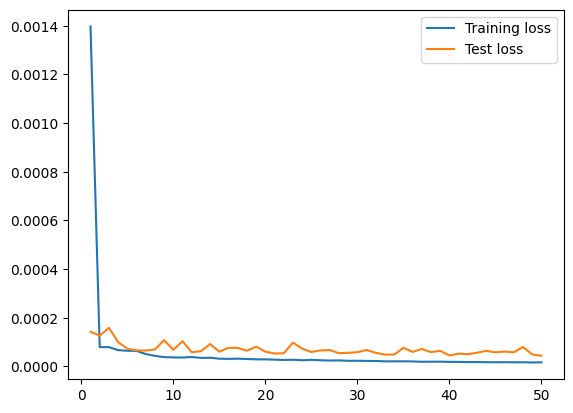

In [5]:
NUM_EPOCHS = 50
# Train the model
#model = model.load_model()

model = model.train_model(loss_fn, optimizer, num_epochs = NUM_EPOCHS).plot_training_test_loss()#.save_model()


In [6]:
model = model.save_model()

In [5]:
model = model.load_model()

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt # Visualization
from sklearn.metrics import mean_squared_error, r2_score

In [18]:
def forecast(model, num_forecast_steps):
    # Define the number of future time steps to forecast
    model.num_forecast_steps = num_forecast_steps
    # Convert to NumPy and remove singleton dimensions
    sequence_to_plot = model.x_test.squeeze().cpu().numpy()
    # Use the last 36 data points as the starting point
    historical_data = sequence_to_plot[-1]
    # Initialize a list to store the forecasted values
    forecasted_values = []

    # Use the trained model to forecast future values
    with torch.no_grad():
        for _ in range(num_forecast_steps):
            # Prepare the historical_data tensor
            historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(model.device)
            # Use the model to predict the next value
            predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]

            # Append the predicted value to the forecasted_values list
            forecasted_values.append(predicted_value)

            # Update the historical_data sequence by removing the oldest value and adding the predicted value
            #historical_data
            historical_data = np.roll(historical_data, shift=-1)
            historical_data[-1] = predicted_value

    #last_date = test_data.index[-1]
    #future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)

    # Generate
    model_psd_data_df = pd.DataFrame(model.psd.data, columns=model.psd.headers)
    psd_ds_dates = model_psd_data_df['p_date'].values.tolist()
    psd_ds_times = model_psd_data_df['p_time'].values.tolist()


    next_date = model.psd.next_max_date

    next_date_ls = [next_date for i in range(num_forecast_steps)]

    psd_ds_dates = psd_ds_dates + next_date_ls

    time_steps_set = ['16:30', '16:35', '16:40', '16:45', '16:50', '16:55', '17:00', '17:05', '17:10', '17:15', '17:20', '17:25', '17:30', '17:35', '17:40', '17:45', '17:50', '17:55', '18:00', '18:05', '18:10', '18:15', '18:20', '18:25', '18:30', '18:35', '18:40', '18:45', '18:50', '18:55', '19:00', '19:05', '19:10', '19:15', '19:20', '19:25', '19:30', '19:35', '19:40', '19:45', '19:50', '19:55', '20:00', '20:05', '20:10', '20:15', '20:20', '20:25' ]
    psd_ds_times = psd_ds_times + time_steps_set

    # Concatenate the original index with the future dates
    model.psd_ds_dates = psd_ds_dates
    model.psd_ds_times = psd_ds_times

    model.forecasted_values = forecasted_values
    model.sequence_to_plot = sequence_to_plot

    return model

In [19]:
FORECAST_STEPS = 48
model = forecast(model, num_forecast_steps = FORECAST_STEPS)


In [1]:
def plot_forecasting(model):
    forecasted_values = model.forecasted_values

    psd_ds_dates = model.psd_ds_dates[-148:]
    psd_ds_times = model.psd_ds_times[-148:]

    # last 100 rows
    psd_ds_datetimes = []

    [psd_ds_datetimes.append(d + " " + t) for d,t in zip(psd_ds_dates, psd_ds_times)]
    #test_data_x = np.float32(model.psd.scaler.inverse_transform(model.x_test.squeeze()).reshape(-1, 1).squeeze())
    #test_data_y = model.psd.scaler.inverse_transform(np.array(model.y_test.squeeze()).reshape(-1, 1)).flatten()
    test_data_y = np.float32(model.y_test.squeeze())

    sequence_to_plot = model.sequence_to_plot

    model_psd_data_df = pd.DataFrame(model.psd.data, columns=model.psd.headers)

    #set the size of the plot
    plt.rcParams['figure.figsize'] = [14, 4]

    #Test data
    plt.plot(psd_ds_datetimes[-120:-48], test_data_y[-72:], label = "input", color = "b")

    #reverse the scaling transformation
    original_cases = model.psd.scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0))#.flatten()
    original_cases = original_cases.reshape(-1, 1).squeeze()

    #the historical data used as input for forecasting
    #plt.plot(psd_ds_datetimes[-96:-48], original_cases, label='actual values', color='green')
    plt.plot(psd_ds_datetimes[-96:-48], test_data_y[-48:], label='actual values', color='green')

    #print(len(psd_ds_datetimes))

    #Forecasted Values
    #reverse the scaling transformation
    #forecasted_cases = self.psd.scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten()
    forecasted_cases = model.psd.scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()
    # plotting the forecasted values
    plt.plot(psd_ds_datetimes[-48:], forecasted_cases, label='forecasted values', color='red')

    plt.xlabel('Time Step')
    plt.ylabel('Value')

    plt.xticks(psd_ds_datetimes, psd_ds_datetimes, rotation='vertical')
    plt.locator_params(axis='x', nbins=len(psd_ds_datetimes)/2)
    plt.tight_layout(pad=4)
    plt.subplots_adjust(bottom=0.15)

    plt.legend()
    plt.title('Time Series Forecasting')
    plt.grid(True)

    #print(f'{test_data_x[-48:]}')

    print(f'{test_data_y[-48:]}')
    #print(f'{len(original_cases)}')

    print(f'original_cases:')
    print(f'{original_cases}')

    print(f'forecasted_cases:')
    print(f'{forecasted_cases}')

    return model

In [2]:
#model = model.load_model()
model = plot_forecasting(model)


NameError: name 'model' is not defined

In [12]:
def model_evaluation(model):
    # Evaluate the model and calculate RMSE and R² score
    model.eval()
    with torch.no_grad():
        test_predictions = []
        for batch_X_test in model.x_test:
            batch_X_test = batch_X_test.to(model.device).unsqueeze(0)  # Add batch dimension
            test_predictions.append(model(batch_X_test).cpu().numpy().flatten()[0])

    test_predictions = np.array(test_predictions)

    # Calculate RMSE and R² score
    rmse = np.sqrt(mean_squared_error(model.y_test.cpu().numpy(), test_predictions))
    r2 = r2_score(model.y_test.cpu().numpy(), test_predictions)

    print(f'RMSE: {rmse:.4f}')
    print(f'R² Score: {r2:.4f}')

    return model

In [13]:
model = model_evaluation(model)#, i_sequence_to_plot, i_forecasted_values, i_combined_index)

RMSE: 0.0066
R² Score: 0.9976


In [ ]:
#model = model.save_model()
print(model.x_test[-5000:-4000])
print(model.y_test[-5000:-4000])
print(model.x_train[-5000:-4000])
print(model.y_train[-5000:-4000])

tensor([[[0.3090],
         [0.3090],
         [0.3090],
         ...,
         [0.3090],
         [0.3090],
         [0.3090]],

        [[0.3090],
         [0.3090],
         [0.3090],
         ...,
         [0.3090],
         [0.3090],
         [0.3090]],

        [[0.3090],
         [0.3090],
         [0.3090],
         ...,
         [0.3090],
         [0.3090],
         [0.3090]],

        ...,

        [[0.2874],
         [0.2874],
         [0.2847],
         ...,
         [0.2857],
         [0.2860],
         [0.2885]],

        [[0.2874],
         [0.2847],
         [0.2847],
         ...,
         [0.2860],
         [0.2885],
         [0.2885]],

        [[0.2847],
         [0.2847],
         [0.2857],
         ...,
         [0.2885],
         [0.2885],
         [0.2918]]])
tensor([[0.3090],
        [0.3090],
        [0.3090],
        [0.3090],
        [0.3090],
        [0.3090],
        [0.3090],
        [0.3090],
        [0.3090],
        [0.3090],
        [0.3090],
        

In [ ]:
'''
# Library for implementing Deep Neural Network
psd2 = psd

from pennystockpipeline.PennyStockModel2 import PennyStockModel2

# Prepare model parameters
INPUT_SIZE = len(COLUMNS_TO_NORMALIZE)
NUM_LAYERS = 2
HIDDEN_SIZE = 32
OUTPUT_SIZE = len(COLUMNS_TO_NORMALIZE)
DROPOUT = 0.2

# Define the model, loss function, and optimizer
model2 = PennyStockModel2(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT, device='cuda')
model2 = model2.to(model2.device)
loss_fn2 = torch.nn.MSELoss(reduction='mean')
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)
print(model2)

BATCH_SIZE = 64
model2 = model2.create_dataloaders(psd2, BATCH_SIZE)
NUM_EPOCHS = 100
# Train the model
#model2 = model2.load_model()
model2 = model2.train_model(loss_fn2, optimizer2, num_epochs = NUM_EPOCHS).plot_training_test_loss()#.save_model()

model2 = model2.forecast(num_forecast_steps = FORECAST_STEPS)
model2 = model2.plot_forecasting()#, i_sequence_to_plot, i_forecasted_values, i_combined_index)
'''